## **simple linear regression analysis**

### **Table 30. Linear regression analysis**

In [ ]:
from scipy import stats

"""log returns of Apple's stock by taking the natural logarithm of the stock prices and
then computing the difference between consecutive log prices."""
data['AAPL_Returns'] = np.log(data['AAPL']).diff()

"""log returns of the S&P 500 index """
data['SP_returns'] = np.log(data['^GSPC']).diff()

"""Removes any rows with NaN values that result from the diff() operation."""
data.dropna(inplace=True)

# linear regresion
(beta,alpha,r_value,p_value,std_err)=stats.linregress(data['SP_returns'], data['AAPL_Returns'])

print(alpha,beta)
print("R-squared=", r_value**2)
print("p-value =", p_value)

0.010860724794190294 1.1308604524157015
R-squared= 0.39233181054402816
p-value = 1.3939912030356463e-19


## **Rolling window**

### **Table 31. Rolling window regression analysis**

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats

stock = 'AAPL'
market_index = '^GSPC'  # S&P 500

data = yf.download([stock, market_index], start='2010-01-01', end='2024-01-01', interval='1mo')['Adj Close']

# Set the index to datetime
data.index = pd.to_datetime(data.index)

# log returns
log_returns = np.log(data).diff().dropna()

# Function to calculate beta
def calculate_beta(X, Y):
    (beta, alpha, r_value, p_value, std_err) = stats.linregress(X, Y)
    return beta

# Rolling window size (3 years of monthly data)
window_size = 36

# Initialize DataFrame for rolling betas
rolling_betas = pd.DataFrame(index=log_returns.index[window_size-1:], columns=[stock])

# Calculate rolling beta
for i in range(len(log_returns) - window_size + 1):
    window_data = log_returns.iloc[i:i + window_size]
    beta = calculate_beta(window_data[market_index], window_data[stock])
    rolling_betas.iloc[i] = beta

print(rolling_betas.head())

[*********************100%%**********************]  2 of 2 completed


                AAPL
Date                
2013-01-01  0.715988
2013-02-01   0.70674
2013-03-01  0.631915
2013-04-01    0.6203
2013-05-01  0.664915


## **Scholes and Williams Adjusted Beta**

### **Table 33. Scholes & Williams Adjusted Beta**

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
from scipy import stats

stock = 'AAPL'
market_index = '^GSPC'

data = yf.download([stock, market_index], start='2010-01-01', end='2024-01-01', interval='1mo')['Adj Close']

data['AAPL_Returns'] = np.log(data[stock]).diff()
data['SP_returns'] = np.log(data[market_index]).diff()

data.dropna(inplace=True)

# contemporaneous beta
(beta_0, alpha_0, r_value_0, p_value_0, std_err_0) = stats.linregress(data['SP_returns'], data['AAPL_Returns'])

# lagged beta
(beta_lag, alpha_lag, r_value_lag, p_value_lag, std_err_lag) = stats.linregress(data['SP_returns'].shift(1).dropna(), data['AAPL_Returns'][1:])

# lead beta
(beta_lead, alpha_lead, r_value_lead, p_value_lead, std_err_lead) = stats.linregress(data['SP_returns'][:-1], data['AAPL_Returns'][1:])

# Combine betas to get the Scholes and Williams adjusted beta
beta_SW = (beta_0 + beta_lag + beta_lead) / 3

print(f"Contemporaneous Beta: {beta_0}")
print(f"Lagged Beta: {beta_lag}")
print(f"Lead Beta: {beta_lead}")
print(f"Scholes and Williams Adjusted Beta: {beta_SW}")


[*********************100%%**********************]  2 of 2 completed

Contemporaneous Beta: 1.1308604524157015
Lagged Beta: -0.04612734097466388
Lead Beta: -0.04612734097466388
Scholes and Williams Adjusted Beta: 0.34620192348879125


## **Hypothesis testing - CAP model**

### **Table 34. Data ingestion**

In [ ]:
# ! pip install pandas yfinance statsmodels
import numpy as np
import pandas as pd
import yfinance as yf

# Historical stock data for AAPL
stock_data = yf.download('TSLA', start='2022-01-01', end='2024-01-01')
stock_data = stock_data['Close']

# Generate hypothetical futures data as a function of stock prices
futures_data = stock_data * 0.95 + np.random.normal(0, 2, len(stock_data))

# Combine the two datasets into a DataFrame
data = pd.DataFrame({'Stock': stock_data, 'Futures': futures_data})
data.head()

[*********************100%%**********************]  1 of 1 completed


,Stock,Futures
Date,,
2022-01-03,399.926666,382.214922
2022-01-04,383.196655,363.190319
2022-01-05,362.706665,345.119509
2022-01-06,354.899994,335.575712
2022-01-07,342.320007,322.426197


### **Table 35. OLS regression**

In [ ]:
import statsmodels.formula.api as sm

formula = 'Stock ~ Futures'
model = sm.ols(formula, data).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Stock   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.548e+05
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:13:26   Log-Likelihood:                -1076.2
No. Observations:                 501   AIC:                             2156.
Df Residuals:                     499   BIC:                             2165.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7754      0.413      1.879      0.0

### **Table 36. Extract hedge ratio**

In [ ]:
# Extract the hedge ratio (slope)
hedge_ratio = model.params.iloc[1]
print(f'Optimal Hedge Ratio: {hedge_ratio}')


Optimal Hedge Ratio: 1.0505767074107426


### **Table 37. Hypothesis test**

In [ ]:
hypotheses = 'Futures = 1'
f_test = model.f_test(hypotheses)
print(f_test)

<F test: F=822.3848648761457, p=1.3626793694355158e-107, df_denom=499, df_num=1>


### **Table 38. Log differences (returns)**

In [ ]:
# Calculate log differences (returns)
data['Stock_Returns'] = np.log(data['Stock']).diff()
data['Futures_Returns'] = np.log(data['Futures']).diff()

# Drop the first row (which will be NaN after differencing)
data = data.dropna()

### **Figure 14. Statistical summary**

In [ ]:
# summary statistics
data.describe()

,Stock,Futures,Stock_Returns,Futures_Returns
count,500.000000,500.000000,500.000000,500.000000
mean,240.010493,227.713288,-0.000952,-0.000984
std,54.977550,52.280051,0.038102,0.040110
min,108.099998,101.067007,-0.130590,-0.139799
25%,197.367496,188.227335,-0.021259,-0.023070
50%,241.661667,230.037576,0.000997,0.000432
75%,276.017509,261.757880,0.020431,0.023578
max,383.196655,363.190319,0.104362,0.116313


### **Table 39. OLS regression using log differenced data**

In [ ]:
import statsmodels.formula.api as sm

formula = 'Stock_Returns ~ Futures_Returns'
model = sm.ols(formula, data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Stock_Returns   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     3547.
Date:                Sat, 03 Aug 2024   Prob (F-statistic):          1.18e-228
Time:                        16:36:58   Log-Likelihood:                 1448.4
No. Observations:                 500   AIC:                            -2893.
Df Residuals:                     498   BIC:                            -2884.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -7.661e-05      0.001     

### **Table 40. Hedge ratio estimation**

In [ ]:
# Extract the hedge ratio (slope)
hedge_ratio = model.params.iloc[1]
print(f'Optimal Hedge Ratio: {hedge_ratio}')

Optimal Hedge Ratio: 0.8895416810232564


### **Table 41. Hypothesis (f-test)**

In [ ]:
hypotheses = 'Futures_Returns = 1'
f_test = model.f_test(hypotheses)
f_test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=54.69014833175215, p=6.025202851037571e-13, df_denom=498, df_num=1>

### **Table 42.  Multiple series ingestion**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.contrast import ContrastResults

# Define a list of stocks and the market index
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
market_index = '^GSPC'  # S&P 500

# Download historical data for the stocks and the market index
data = yf.download(stocks + [market_index], start='2010-01-01', end='2024-01-01', interval='1mo')['Adj Close']
# date is set as the index
data.index = pd.to_datetime(data.index)
data

[*********************100%%**********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,^GSPC
Date,,,,,
2010-01-01,5.799201,6.270500,13.246559,21.296068,1073.869995
2010-02-01,6.178447,5.920000,13.168070,21.666361,1104.489990
2010-03-01,7.095764,6.788500,14.175922,22.238419,1169.430054
2010-04-01,7.883545,6.855000,13.140574,23.187483,1186.689941
2010-05-01,7.756425,6.273000,12.138970,19.588640,1089.410034
...,...,...,...,...,...
2023-08-01,186.877518,138.009995,136.013901,325.215973,4507.660156
2023-09-01,170.535538,127.120003,130.709991,313.962463,4288.049805
2023-10-01,170.097260,133.089996,123.937759,336.195892,4193.799805


### **Table 43. Return series**

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
from scipy import stats
from pandas_datareader import data as pdr
import datetime as dt

stock = 'AAPL'
market_index = '^GSPC'

data = yf.download([stock, market_index], start='2010-01-01', end='2024-01-01', interval='1mo')['Adj Close']

data['AAPL_Returns'] = np.log(data[stock]).diff()
data['SP_returns'] = np.log(data[market_index]).diff()


# Set the start and end dates for the data
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2024,1,1)

# Risk-free rate data (using 3-month Treasury Bill as proxy from FRED) at monthly frequency
data['risk_free_rate'] = pdr.get_data_fred('DGS3MO', start=start, end=end)
data['risk_free_rate'].index = pd.to_datetime(data['risk_free_rate'].index)
data

[*********************100%%**********************]  2 of 2 completed


Ticker,AAPL,^GSPC,AAPL_Returns,SP_returns,risk_free_rate
Date,,,,,
2010-01-01,5.799203,1073.869995,NaN,NaN,NaN
2010-02-01,6.178449,1104.489990,0.063347,0.028115,0.10
2010-03-01,7.095762,1169.430054,0.138430,0.057133,0.13
2010-04-01,7.883546,1186.689941,0.105280,0.014651,0.16
2010-05-01,7.756424,1089.410034,-0.016256,-0.085532,NaN
...,...,...,...,...,...
2023-08-01,186.877533,4507.660156,-0.044658,-0.017875,5.54
2023-09-01,170.535522,4288.049805,-0.091510,-0.049946,5.53
2023-10-01,170.097260,4193.799805,-0.002573,-0.022225,NaN


### **Table 44. Plots of return series (line and scatter plots)**

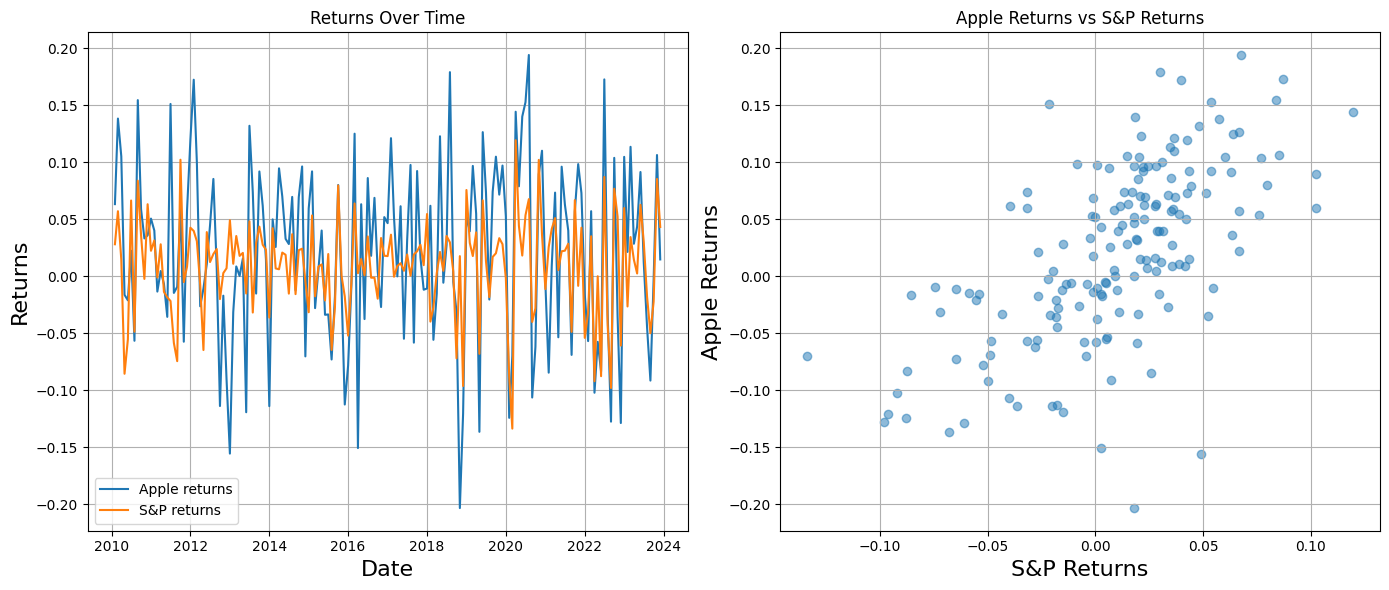

In [ ]:
from matplotlib import pyplot as plt

# Plot both line plot and scatter plot in a single row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Line plot
ax1.plot(data['AAPL_Returns'], label='Apple returns')
ax1.plot(data['SP_returns'], label='S&P returns')
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Returns', fontsize=16)
ax1.set_title('Returns Over Time')
ax1.grid(True)
ax1.legend()

# Scatter plot
ax2.scatter(data['SP_returns'], data['AAPL_Returns'], alpha=0.5)
ax2.set_xlabel('S&P Returns', fontsize=16)
ax2.set_ylabel('Apple Returns', fontsize=16)
ax2.set_title('Apple Returns vs S&P Returns')
ax2.grid(True)

plt.tight_layout()
plt.show()


### **Table 45. Implementation of excess returns**

In [ ]:
data = data.dropna()
data.loc[:,'AAPL_ExcessReturns'] = data.loc[:,'AAPL_Returns'] - data.loc[:,'risk_free_rate']
data.loc[:, 'SP_ExcessReturns'] = data.loc[:,'SP_returns'] - data.loc[:,'risk_free_rate']
data.head()


Ticker,AAPL,^GSPC,AAPL_Returns,SP_returns,risk_free_rate,AAPL_ExcessReturns,SP_ExcessReturns
Date,,,,,,,
2010-02-01,6.178449,1104.489990,0.063347,0.028115,0.10,-0.036653,-0.071885
2010-03-01,7.095762,1169.430054,0.138430,0.057133,0.13,0.008430,-0.072867
2010-04-01,7.883546,1186.689941,0.105280,0.014651,0.16,-0.054720,-0.145349
2010-06-01,7.594882,1030.709961,-0.021047,-0.055388,0.16,-0.181047,-0.215388
2010-07-01,7.767600,1101.599976,0.022487,0.066516,0.17,-0.147513,-0.103484


### **Table 46. OLS regression on excess returns**

In [ ]:
import statsmodels.formula.api as sm

formula = 'AAPL_ExcessReturns ~ SP_ExcessReturns'
model = sm.ols(formula, data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     AAPL_ExcessReturns   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 6.498e+04
Date:                Sat, 03 Aug 2024   Prob (F-statistic):          3.85e-153
Time:                        16:47:23   Log-Likelihood:                 150.43
No. Observations:                 111   AIC:                            -296.9
Df Residuals:                     109   BIC:                            -291.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0200      0.007  

### **Table 47. Hypotheses testing**

In [ ]:
hypotheses = 'SP_ExcessReturns = 1'
f_test = model.f_test(hypotheses)
print(f_test)

# F-test: multiple hypothesis tests
hypotheses = 'SP_ExcessReturns = Intercept = 1'
f_test = model.f_test(hypotheses)
print(f_test)


<F test: F=1.0635155130370995, p=0.30469758498565036, df_denom=109, df_num=1>
<F test: F=13547.465262624151, p=2.2507063093832185e-131, df_denom=109, df_num=2>


## **Quantile regression**

### **Table 48. Quantile regression implementation**

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.formula.api as sm

# Define a list of stocks and the market index
stocks = ['AAPL']
market_index = '^GSPC'

data = yf.download(stocks + [market_index], start='2010-01-01', end='2024-01-01', interval='1mo')['Adj Close']
data.index = pd.to_datetime(data.index)

data['risk_free_rate'] = pdr.get_data_fred('DGS3MO', start=start, end=end)
data['risk_free_rate'].index = pd.to_datetime(data['risk_free_rate'].index)

data['AAPL_ExcessReturns'] = np.log(data['AAPL']).diff() - data['risk_free_rate']
data['SP_ExcessReturns'] = np.log(data['^GSPC']).diff() - data['risk_free_rate']
data = data.dropna()

# quantiles
quantiles = np.arange(0.10, 1.00, 0.10)

# Initialize a list to store the results
results_list = []

# Loop through the quantiles and fit models
for q in quantiles:
    model = sm.quantreg('AAPL_ExcessReturns ~ SP_ExcessReturns', data).fit(q=q)
    summary_df = model.summary2().tables[1]
    summary_df['Quantile'] = q
    results_list.append(summary_df)

# Combine all results
combined_results = pd.concat(results_list)

# Reset index
combined_results.reset_index(inplace=True)

combined_results

[*********************100%%**********************]  2 of 2 completed


,index,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],Quantile
0,Intercept,-0.053940,0.010494,-5.140257,1.215760e-06,-0.074738,-0.033142,0.1
1,SP_ExcessReturns,1.005802,0.005284,190.360153,2.386367e-139,0.995330,1.016274,0.1
2,Intercept,-0.026990,0.009826,-2.746804,7.042651e-03,-0.046464,-0.007515,0.2
3,SP_ExcessReturns,1.002612,0.005717,175.374657,1.764451e-135,0.991281,1.013942,0.2
4,Intercept,-0.017008,0.010358,-1.642066,1.034585e-01,-0.037537,0.003521,0.3
5,SP_ExcessReturns,1.002128,0.006029,166.225853,5.935854e-133,0.990179,1.014077,0.3
6,Intercept,0.000012,0.010091,0.001166,9.990719e-01,-0.019988,0.020012,0.4
7,SP_ExcessReturns,1.004821,0.005752,174.689112,2.700019e-135,0.993421,1.016221,0.4
8,Intercept,0.024839,0.009629,2.579519,1.122518e-02,0.005754,0.043924,0.5
9,SP_ExcessReturns,1.005595,0.005383,186.799213,1.857545e-138,0.994925,1.016264,0.5


### **Table 49. Quantile regression plots**

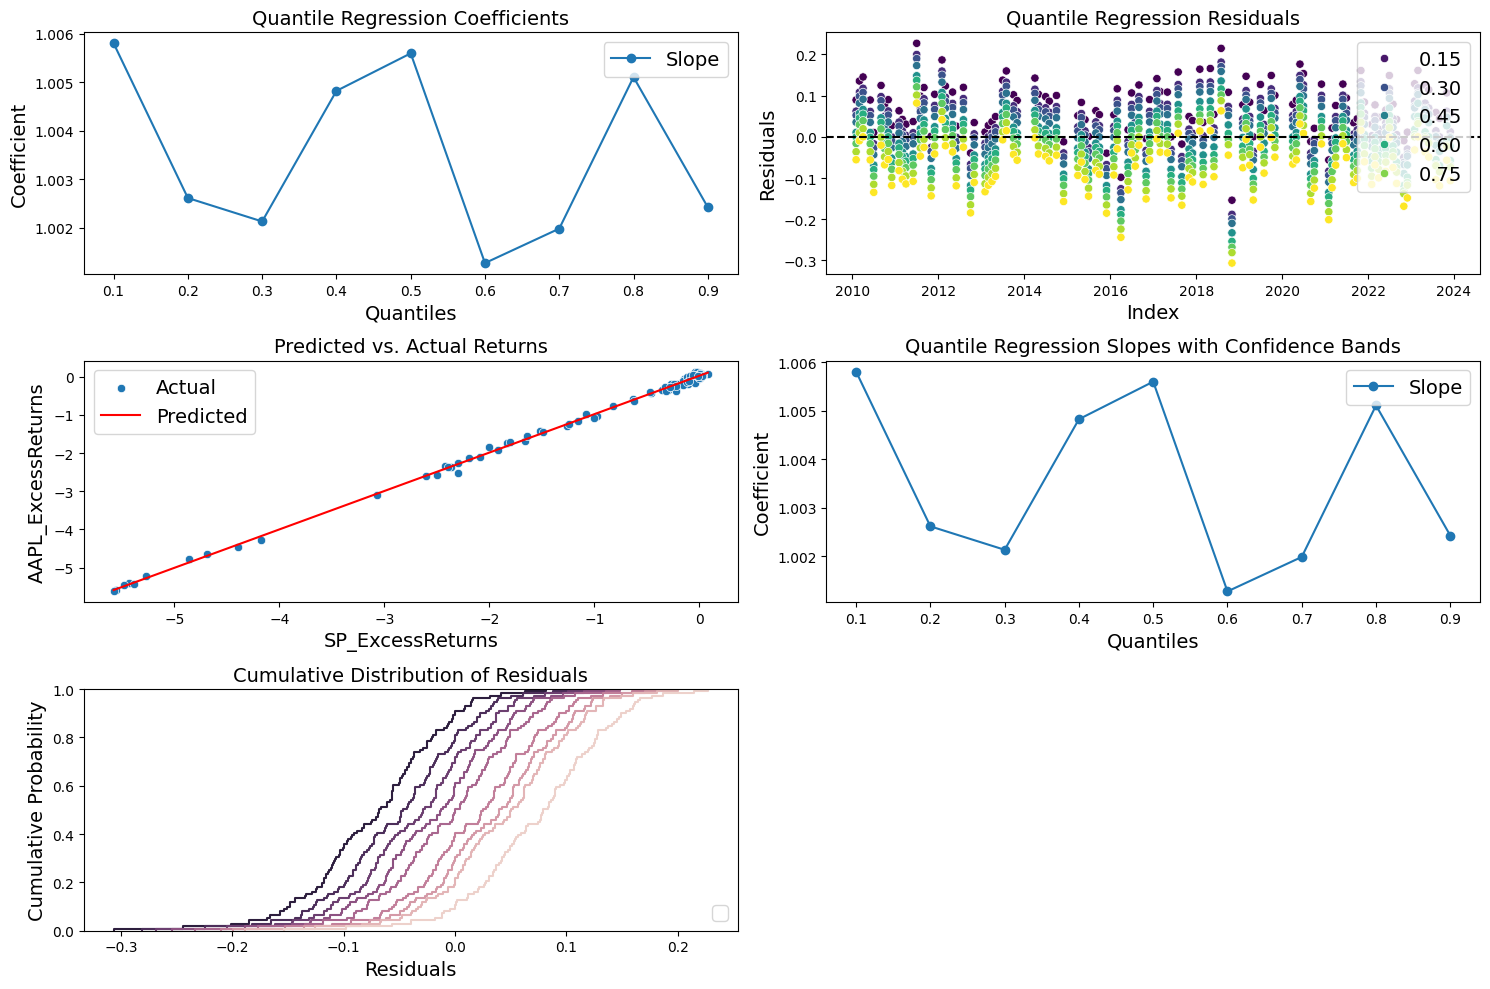

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm

quantiles = np.arange(0.1, 1.0, 0.1)
models = [sm.quantreg('AAPL_ExcessReturns ~ SP_ExcessReturns', data).fit(q=q) for q in quantiles]

# Extracting coefficients and confidence intervals
coefs = pd.DataFrame([model.params for model in models], index=quantiles)
conf_ints = pd.DataFrame([model.conf_int().loc['SP_ExcessReturns'] for model in models], index=quantiles, columns=['2.5%', '97.5%'])

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fontsize = 14

# 1. Quantile Regression Coefficients Plot
axes[0, 0].plot(coefs.index, coefs['SP_ExcessReturns'], label='Slope', marker='o')
axes[0, 0].set_xlabel('Quantiles', fontsize=fontsize)
axes[0, 0].set_ylabel('Coefficient', fontsize=fontsize)
axes[0, 0].set_title('Quantile Regression Coefficients', fontsize=fontsize)
axes[0, 0].legend(fontsize=fontsize)

# 2. Quantile Regression Residuals Plot
residuals = pd.DataFrame({'Residuals': models[4].resid, 'Quantile': 0.5})
for model in models:
    residuals = pd.concat([residuals, pd.DataFrame({'Residuals': model.resid, 'Quantile': model.q})])
sns.scatterplot(x=residuals.index, y='Residuals', hue='Quantile', data=residuals, palette='viridis', ax=axes[0, 1])
axes[0, 1].axhline(0, color='k', linestyle='--')
axes[0, 1].set_xlabel('Index', fontsize=fontsize)
axes[0, 1].set_ylabel('Residuals', fontsize=fontsize)
axes[0, 1].set_title('Quantile Regression Residuals', fontsize=fontsize)
axes[0, 1].legend(loc='upper right', fontsize=fontsize)

# 3. Predicted vs. Actual Returns Plot
quantile = 0.5
model_median = sm.quantreg('AAPL_ExcessReturns ~ SP_ExcessReturns', data).fit(q=quantile)
data['Predicted'] = model_median.predict(data['SP_ExcessReturns'])
sns.scatterplot(x='SP_ExcessReturns', y='AAPL_ExcessReturns', data=data, ax=axes[1, 0], label='Actual')
sns.lineplot(x='SP_ExcessReturns', y='Predicted', data=data, color='r', ax=axes[1, 0], label='Predicted')
axes[1, 0].set_xlabel('SP_ExcessReturns', fontsize=fontsize)
axes[1, 0].set_ylabel('AAPL_ExcessReturns', fontsize=fontsize)
axes[1, 0].set_title('Predicted vs. Actual Returns', fontsize=fontsize)
axes[1, 0].legend(fontsize=fontsize)

# 4. Quantile Regression Slopes with Confidence Bands
axes[1, 1].plot(coefs.index, coefs['SP_ExcessReturns'], label='Slope', marker='o')
axes[1, 1].fill_between(conf_ints.index, conf_ints['2.5%'], conf_ints['97.5%'], color='b', alpha=0.2)
axes[1, 1].set_xlabel('Quantiles', fontsize=fontsize)
axes[1, 1].set_ylabel('Coefficient', fontsize=fontsize)
axes[1, 1].set_title('Quantile Regression Slopes with Confidence Bands', fontsize=fontsize)
axes[1, 1].legend(fontsize=fontsize)

# 5. Cumulative Distribution of Residuals
sns.ecdfplot(data=residuals, x='Residuals', hue='Quantile', ax=axes[2, 0])
axes[2, 0].set_xlabel('Residuals', fontsize=fontsize)
axes[2, 0].set_ylabel('Cumulative Probability', fontsize=fontsize)
axes[2, 0].set_title('Cumulative Distribution of Residuals', fontsize=fontsize)
axes[2, 0].legend(loc='lower right', fontsize=fontsize)

# Hide the empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()



## **3-factor model**

In [ ]:
pip install getFamaFrenchFactors

### **Table 50. Data ingestion for 3 factor model**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm


start = dt.datetime(2010, 1, 1)
end = dt.datetime.now()

# Fetch AAPL and S&P 500 data from Yahoo Finance
stock = 'AAPL'
market_index = '^GSPC'

data = yf.download([stock, market_index], start=start, end=end, interval='1mo')['Adj Close']

# Calculate monthly returns
data['AAPL_Returns'] = np.log(data[stock] / data[stock].shift(1))
data['Market_Returns'] = np.log(data[market_index] / data[market_index].shift(1))

# Drop missing values
data = data.dropna()
data.reset_index(inplace=True)
data.head()

[*********************100%%**********************]  2 of 2 completed


Ticker,Date,AAPL,^GSPC,AAPL_Returns,Market_Returns
0,2010-02-01,6.178448,1104.489990,0.063347,0.028115
1,2010-03-01,7.095762,1169.430054,0.138431,0.057133
2,2010-04-01,7.883545,1186.689941,0.105280,0.014651
3,2010-05-01,7.756422,1089.410034,-0.016257,-0.085532
4,2010-06-01,7.594885,1030.709961,-0.021046,-0.055388


### **Table 51. 3-month treasury bill**

In [ ]:
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt

# Set the start and end dates for the data
start = dt.datetime(2010, 1, 1)
end = dt.datetime.now()

# Fetch the 3-month Treasury Bill rate (risk-free rate) from FRED
rf_data = pdr.get_data_fred('DGS3MO', start=start, end=end)
rf_data = rf_data.resample('M').last() / 100  # Convert to monthly frequency and from percentage to decima
rf_data.reset_index(inplace=True)
rf_data.columns = ['Date', 'RF']
rf_data

,Date,RF
0,2010-01-31,0.0008
1,2010-02-28,0.0013
2,2010-03-31,0.0016
3,2010-04-30,0.0016
4,2010-05-31,0.0016
...,...,...
170,2024-03-31,0.0546
171,2024-04-30,0.0546
172,2024-05-31,0.0546
173,2024-06-30,0.0548


### **Table 52. Merge the risk-free rate with the main dataset**

In [ ]:
# Merge the risk-free rate with the main dataset
data = pd.concat([data, rf_data['RF']], axis=1)
data.set_index('Date', inplace=True)
data['AAPL_ExcessReturns'] = data['AAPL_Returns'] - data['RF']
data.head()

,AAPL,^GSPC,AAPL_Returns,Market_Returns,RF,AAPL_ExcessReturns
Date,,,,,,
2010-02-01,6.178448,1104.489990,0.063347,0.028115,0.0008,0.062547
2010-03-01,7.095762,1169.430054,0.138431,0.057133,0.0013,0.137131
2010-04-01,7.883545,1186.689941,0.105280,0.014651,0.0016,0.103680
2010-05-01,7.756422,1089.410034,-0.016257,-0.085532,0.0016,-0.017857
2010-06-01,7.594885,1030.709961,-0.021046,-0.055388,0.0016,-0.022646


### **Table 53. Fama French factors**

In [ ]:
import getFamaFrenchFactors as gff

# Get Fama-French 3-factor data
ff3 = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
# Ensure the date column is in datetime format and set it as index
ff3['date_ff_factors'] = pd.to_datetime(ff3['date_ff_factors'], format='%Y%m')
ff3 = ff3.set_index('date_ff_factors')
ff3.index = ff3.index + pd.offsets.MonthBegin(1)
ff3 = ff3.tail(174)
ff3

,Mkt-RF,SMB,HML,RF
date_ff_factors,,,,
2010-02-01,-0.0336,0.0040,0.0043,0.0000
2010-03-01,0.0340,0.0119,0.0323,0.0000
2010-04-01,0.0631,0.0148,0.0221,0.0001
2010-05-01,0.0200,0.0487,0.0289,0.0001
2010-06-01,-0.0789,0.0009,-0.0244,0.0001
...,...,...,...,...
2024-03-01,0.0506,-0.0016,-0.0354,0.0042
2024-04-01,0.0283,-0.0246,0.0416,0.0043
2024-05-01,-0.0467,-0.0234,-0.0054,0.0047


### **Table 54. Merging FamaFench factors with the original data**

In [ ]:
# Merge datasets on the date index
merged_data = pd.merge(data, ff3, left_index=True, right_index=True, how='inner')

# Check for missing values
print('Missing values in the data: ', merged_data.isna().sum())

Missing values in the data:  AAPL                  0
^GSPC                 0
AAPL_Returns          0
Market_Returns        0
RF_x                  0
AAPL_ExcessReturns    0
Mkt-RF                0
SMB                   0
HML                   0
RF_y                  0
dtype: int64


In [ ]:
merged_data.head()

,AAPL,^GSPC,AAPL_Returns,Market_Returns,RF_x,AAPL_ExcessReturns,Mkt-RF,SMB,HML,RF_y
2010-02-01,6.178448,1104.489990,0.063347,0.028115,0.0008,0.062547,-0.0336,0.0040,0.0043,0.0000
2010-03-01,7.095762,1169.430054,0.138431,0.057133,0.0013,0.137131,0.0340,0.0119,0.0323,0.0000
2010-04-01,7.883545,1186.689941,0.105280,0.014651,0.0016,0.103680,0.0631,0.0148,0.0221,0.0001
2010-05-01,7.756422,1089.410034,-0.016257,-0.085532,0.0016,-0.017857,0.0200,0.0487,0.0289,0.0001
2010-06-01,7.594885,1030.709961,-0.021046,-0.055388,0.0016,-0.022646,-0.0789,0.0009,-0.0244,0.0001


### **Table 55. Visual comparison plots**

<Figure size 640x480 with 0 Axes>

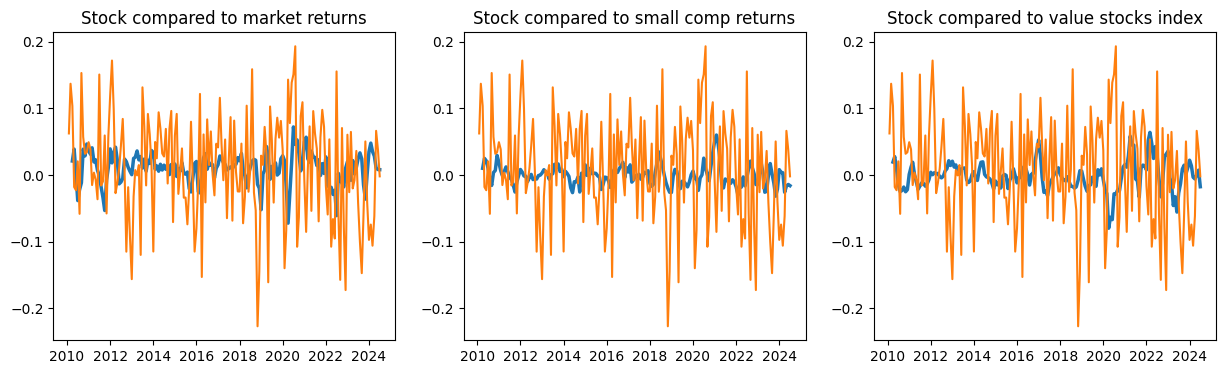

In [ ]:
from matplotlib import pyplot as plt

#set names for the target variable and factors:
stock = 'AAPL_ExcessReturns'
factors = ['Mkt-RF', 'SMB', 'HML']

# plot fama-french factors:
plt.figure()
fig3, axs = plt.subplots(1, 3,figsize=(15, 4))
axs[0].plot(merged_data['Mkt-RF'].rolling(3).mean(),linewidth=2.5)
axs[0].plot(merged_data[stock])
axs[0].set_title('Stock compared to market returns')
axs[1].plot(merged_data['SMB'].rolling(3).mean(),linewidth=2.5)
axs[1].plot(merged_data[stock])
axs[1].set_title('Stock compared to small comp returns')
axs[2].plot(merged_data['HML'].rolling(3).mean(),linewidth=2.5)
axs[2].plot(merged_data[stock])
axs[2].set_title('Stock compared to value stocks index')
# fig3.suptitle('Factors plot',fontsize=18)
plt.show()

### **Table 56. FamaFench 3-factors model**

In [ ]:
X = sm.add_constant(merged_data[['Mkt-RF', 'SMB', 'HML']])
Y = merged_data['AAPL_ExcessReturns']

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     AAPL_ExcessReturns   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.185
Date:                Fri, 02 Aug 2024   Prob (F-statistic):              0.317
Time:                        10:50:52   Log-Likelihood:                 196.91
No. Observations:                 174   AIC:                            -385.8
Df Residuals:                     170   BIC:                            -373.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0107      0.006      1.729      0.0

## **Arbitrage pricing theory**


### **Table 57.  Crude oil and SP 500 series**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# Western Texas crude oil (CL=F) and the market index S&P
stocks = ['CL=F']
market_index = '^GSPC'

# Historical data at monthly frequency
data = yf.download(stocks + [market_index], start='2010-01-01', end='2024-01-01', interval='1mo')['Adj Close']

# Ensure the date is set as the index
data.index = pd.to_datetime(data.index)
data

[*********************100%%**********************]  2 of 2 completed


Ticker,CL=F,^GSPC
Date,,
2010-01-01,72.889999,1073.869995
2010-02-01,79.660004,1104.489990
2010-03-01,83.760002,1169.430054
2010-04-01,86.150002,1186.689941
2010-05-01,73.970001,1089.410034
...,...,...
2023-08-01,83.629997,4507.660156
2023-09-01,90.790001,4288.049805
2023-10-01,NaN,4193.799805


In [ ]:
stocks = ['CL=F']
market_index = '^GSPC'

data = yf.download(stocks + [market_index], start='2010-01-01', end='2024-01-01', interval='1mo')['Adj Close']

data.index = pd.to_datetime(data.index)
data.reset_index(inplace=True)
data

[*********************100%%**********************]  2 of 2 completed


Ticker,Date,CL=F,^GSPC
0,2010-01-01,72.889999,1073.869995
1,2010-02-01,79.660004,1104.489990
2,2010-03-01,83.760002,1169.430054
3,2010-04-01,86.150002,1186.689941
4,2010-05-01,73.970001,1089.410034
...,...,...,...
163,2023-08-01,83.629997,4507.660156
164,2023-09-01,90.790001,4288.049805
165,2023-10-01,NaN,4193.799805
166,2023-11-01,75.959999,4567.799805


### **Table 58. FRED macroeconomic data ingestion**

In [ ]:
# Total Consumer Credit Owned and Securitized from FRED
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt

# Set the start and end dates for the data
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2024,1,1)

cpiaucsl = pdr.get_data_fred('CPIAUCSL', start=start, end=end)
cpiaucsl.reset_index(inplace=True)
cpiaucsl

,DATE,CPIAUCSL
0,2010-01-01,217.488
1,2010-02-01,217.281
2,2010-03-01,217.353
3,2010-04-01,217.403
4,2010-05-01,217.290
...,...,...
164,2023-09-01,307.288
165,2023-10-01,307.531
166,2023-11-01,308.024
167,2023-12-01,308.742


In [ ]:
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt

# Set the start and end dates for the data
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2024,1,1)

# risk-free rate data from FRED
fred_code = 'DGS3MO'

# Fetch the 3-month Treasury Bill rate (risk-free rate) from FRED
dgs3mo = pdr.get_data_fred(fred_code, start=start, end=end)
dgs3mo = dgs3mo.resample('M').last() / 100  # Convert to monthly frequency and from percentage to decima
dgs3mo.reset_index(inplace=True)
dgs3mo

,DATE,DGS3MO
0,2010-01-31,0.0008
1,2010-02-28,0.0013
2,2010-03-31,0.0016
3,2010-04-30,0.0016
4,2010-05-31,0.0016
...,...,...
164,2023-09-30,0.0555
165,2023-10-31,0.0559
166,2023-11-30,0.0545
167,2023-12-31,0.0540


In [ ]:
# Fetch the 10-year Treasury Bill rate (risk-free rate) from FRED
DGS10 = pdr.get_data_fred('DGS10', start=start, end=end)
DGS10 = DGS10.resample('M').last() / 100  # Convert to monthly frequency and from percentage to decimal
DGS10.reset_index(inplace=True)
DGS10

,DATE,DGS10
0,2010-01-31,0.0363
1,2010-02-28,0.0361
2,2010-03-31,0.0384
3,2010-04-30,0.0369
4,2010-05-31,0.0331
...,...,...
164,2023-09-30,0.0459
165,2023-10-31,0.0488
166,2023-11-30,0.0437
167,2023-12-31,0.0388


In [ ]:
# GDP from FRED
gdp = pdr.get_data_fred('GDP', start=start, end=end)
gdp = gdp.resample('M').bfill().ffill()
gdp.reset_index(inplace=True)
gdp

,DATE,GDP
0,2010-01-31,14980.193
1,2010-02-28,14980.193
2,2010-03-31,14980.193
3,2010-04-30,15141.607
4,2010-05-31,15141.607
...,...,...
164,2023-09-30,27956.998
165,2023-10-31,28269.174
166,2023-11-30,28269.174
167,2023-12-31,28269.174


In [ ]:
# Unemployment rate from FRED
unrate = pdr.get_data_fred('UNRATE', start=start, end=end)
unrate.reset_index(inplace=True)
unrate

,DATE,UNRATE
0,2010-01-01,9.8
1,2010-02-01,9.8
2,2010-03-01,9.9
3,2010-04-01,9.9
4,2010-05-01,9.6
...,...,...
164,2023-09-01,3.8
165,2023-10-01,3.8
166,2023-11-01,3.7
167,2023-12-01,3.7


In [ ]:
# industrial production from FRED
indpro = pdr.get_data_fred('INDPRO', start=start, end=end)
indpro.reset_index(inplace=True)
indpro

,DATE,INDPRO
0,2010-01-01,89.1897
1,2010-02-01,89.5046
2,2010-03-01,90.1356
3,2010-04-01,90.4607
4,2010-05-01,91.7014
...,...,...
164,2023-09-01,103.3081
165,2023-10-01,102.5781
166,2023-11-01,102.8868
167,2023-12-01,102.6309


In [ ]:
# Total Consumer Credit Owned and Securitized from FRED
totalsl = pdr.get_data_fred('TOTALSL', start=start, end=end)
totalsl.reset_index(inplace=True)
totalsl

,DATE,TOTALSL
0,2010-01-01,2543.50802
1,2010-02-01,2530.02428
2,2010-03-01,2536.55195
3,2010-04-01,2532.76479
4,2010-05-01,2521.68794
...,...,...
164,2023-09-01,4991.34967
165,2023-10-01,5000.73746
166,2023-11-01,5018.97589
167,2023-12-01,5023.69958


In [ ]:
# Money Stock Measures from FRED
m2sl = pdr.get_data_fred('M2SL', start=start, end=end)
m2sl.reset_index(inplace=True)
m2sl

,DATE,M2SL
0,2010-01-01,8458.1
1,2010-02-01,8507.4
2,2010-03-01,8504.5
3,2010-04-01,8535.2
4,2010-05-01,8589.9
...,...,...
164,2023-09-01,20709.9
165,2023-10-01,20690.3
166,2023-11-01,20703.3
167,2023-12-01,20751.8


In [ ]:
# volatility index
market_index = '^VIX'

# Download historical data for the stocks and the market index at monthly frequency
vix = yf.download([market_index], start='2010-01-01', end='2024-01-01', interval='1mo')['Adj Close']
vix = vix.reset_index()
vix.rename(columns={'Adj Close': 'VIX'}, inplace=True)
vix.head()

[*********************100%%**********************]  1 of 1 completed


,Date,VIX
0,2010-01-01,24.620001
1,2010-02-01,19.500000
2,2010-03-01,17.590000
3,2010-04-01,22.049999
4,2010-05-01,32.070000


### **Combine all data in a dataframe**

In [ ]:
data = pd.concat([data, cpiaucsl['CPIAUCSL'], dgs3mo['DGS3MO'], DGS10['DGS10'], gdp['GDP'],
           unrate['UNRATE'], indpro['INDPRO'], totalsl['TOTALSL'], m2sl['M2SL'], vix['VIX']], axis=1)
data = data.set_index('Date')
print(data.head())

                 CL=F        ^GSPC  CPIAUCSL  DGS3MO   DGS10        GDP  \
Date                                                                      
2010-01-01  72.889999  1073.869995   217.488  0.0008  0.0363  14980.193   
2010-02-01  79.660004  1104.489990   217.281  0.0013  0.0361  14980.193   
2010-03-01  83.760002  1169.430054   217.353  0.0016  0.0384  14980.193   
2010-04-01  86.150002  1186.689941   217.403  0.0016  0.0369  15141.607   
2010-05-01  73.970001  1089.410034   217.290  0.0016  0.0331  15141.607   

            UNRATE   INDPRO     TOTALSL    M2SL        VIX  
Date                                                        
2010-01-01     9.8  89.1897  2543.50802  8458.1  24.620001  
2010-02-01     9.8  89.5046  2530.02428  8507.4  19.500000  
2010-03-01     9.9  90.1356  2536.55195  8504.5  17.590000  
2010-04-01     9.9  90.4607  2532.76479  8535.2  22.049999  
2010-05-01     9.6  91.7014  2521.68794  8589.9  32.070000  


### **Table 59. Data transformation**

In [ ]:
data = data.dropna()
df = pd.DataFrame()

"""log return of crude oil prices and then adjusts for the risk-free rate on a monthly basis.
This transformation is for capturing the excess return relative to the risk-free rate."""

df['CL_ExcessReturns'] = np.log(data['CL=F']).diff() - data['DGS3MO']/12

# log return of the S&P 500 and adjusts for the risk-free rate.
df['SP_ExcessReturns'] = np.log(data['^GSPC']).diff() - data['DGS3MO']/12

"""changes in industrial production from the previous period.
This transformation captures the month-to-month change, which is appropriate for time series analysis."""
df['indpro'] = data['INDPRO'] - data['INDPRO'].shift(1)

# This calculates the monthly inflation rate as a percentage change in the Consumer Price Index (CPI).
df['inflation'] = (data['CPIAUCSL'].diff() / data['CPIAUCSL'].shift(1)) * 100

"""This calculates the log difference of total consumer credit, which represents the percentage change in credit.
Here we are analyzing growth rates of consumer credit."""
df['ConsumerCredit'] = np.log(data['TOTALSL']) - np.log(data['TOTALSL'].shift(1))

# This calculates the change in the term spread, which measures the difference between long-term and short-term interest rates.
df['termSpread'] = (data['DGS10'] - data['DGS3MO']) - (data['DGS10'] - data['DGS3MO']).shift(1)

# yield spread between long-term and short-term interest rates.
df['yieldSpread'] = data['DGS10'] - data['DGS3MO']

# This calculates the log difference of M2 money stock, representing the growth rate in M2 money supply.
df['m2sl'] = np.log(data['M2SL']) - np.log(data['M2SL']).shift(1)

# It is already a volatility measure and not a growth or price level, so we take absolute changes.
df['vix'] = data['VIX']- data['VIX'].shift(1)

# Change in Unemployment Rate
df['unrate'] = data['UNRATE'] - data['UNRATE'].shift(1)

df.dropna(inplace=True)
print(df.head())

            CL_ExcessReturns  SP_ExcessReturns  indpro  inflation  \
Date                                                                
2010-02-01          0.088708          0.028006  0.3149  -0.095178   
2010-03-01          0.050055          0.056999  0.6310   0.033137   
2010-04-01          0.028001          0.014518  0.3251   0.023004   
2010-05-01         -0.152564         -0.085665  1.2407  -0.051977   
2010-06-01          0.022043         -0.055538  0.2019  -0.041880   

            ConsumerCredit  termSpread  yieldSpread      m2sl        vix  \
Date                                                                       
2010-02-01       -0.005315     -0.0007       0.0348  0.005812  -5.120001   
2010-03-01        0.002577      0.0020       0.0368 -0.000341  -1.910000   
2010-04-01       -0.001494     -0.0015       0.0353  0.003603   4.459999   
2010-05-01       -0.004383     -0.0038       0.0315  0.006388  10.020000   
2010-06-01       -0.001298     -0.0036       0.0279  0.00222

### **Table 61. OLS multifactor model**

In [ ]:
import statsmodels.formula.api as sm

formula = 'CL_ExcessReturns ~ SP_ExcessReturns + inflation + indpro + termSpread + yieldSpread + ConsumerCredit'
model1 = sm.ols(formula, df).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:       CL_ExcessReturns   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     17.16
Date:                Sun, 04 Aug 2024   Prob (F-statistic):           1.52e-14
Time:                        02:56:33   Log-Likelihood:                 122.65
No. Observations:                 137   AIC:                            -231.3
Df Residuals:                     130   BIC:                            -210.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0309      0.018  

### **Table 60. Pearson correlation**

In [ ]:
df[['SP_ExcessReturns', 'inflation', 'termSpread', 'yieldSpread', 'indpro', 'ConsumerCredit']].corr(method='pearson')

,SP_ExcessReturns,inflation,termSpread,yieldSpread,indpro,ConsumerCredit
SP_ExcessReturns,1.000000,0.075480,0.163152,0.027303,0.084118,0.124863
inflation,0.075480,1.000000,-0.049246,-0.045384,0.365653,0.399467
termSpread,0.163152,-0.049246,1.000000,0.215993,-0.261985,0.000015
yieldSpread,0.027303,-0.045384,0.215993,1.000000,0.070258,0.062563
indpro,0.084118,0.365653,-0.261985,0.070258,1.000000,0.276254
ConsumerCredit,0.124863,0.399467,0.000015,0.062563,0.276254,1.000000


### **Table 62. Variable inflation factor implementation**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Extracting the independent variables
X = df[['SP_ExcessReturns', 'inflation', 'termSpread', 'yieldSpread', 'indpro', 'ConsumerCredit']]
# Calculating VIF
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

           Variable       VIF
0  SP_ExcessReturns  1.092803
1         inflation  1.771247
2        termSpread  1.112797
3       yieldSpread  1.446858
4            indpro  1.213607
5    ConsumerCredit  1.845463


### **Table 63. Null hypothesis test**

In [ ]:
hypotheses = 'ConsumerCredit = yieldSpread = 0'
fTest = model1.f_test(hypotheses)
print(fTest)

<F test: F=0.09627854326549806, p=0.9082757025434491, df_denom=130, df_num=2>


### **Table 64. Residuals pattern**

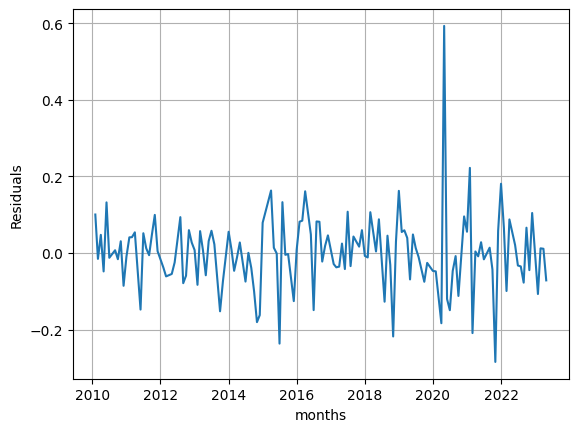

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model1.resid)
plt.xlabel('months')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

### **Table 65. Distribution of residuals**

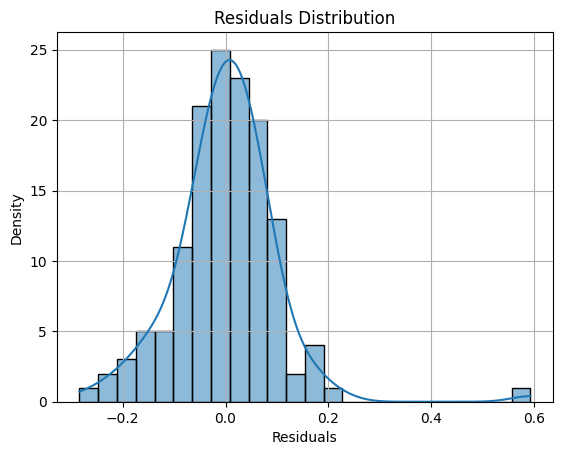

In [ ]:
import seaborn as sns

# Distribution of residuals
sns.histplot(model1.resid, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals Distribution')
plt.grid()
plt.show()

### **Table 66. Histogram with different bins**

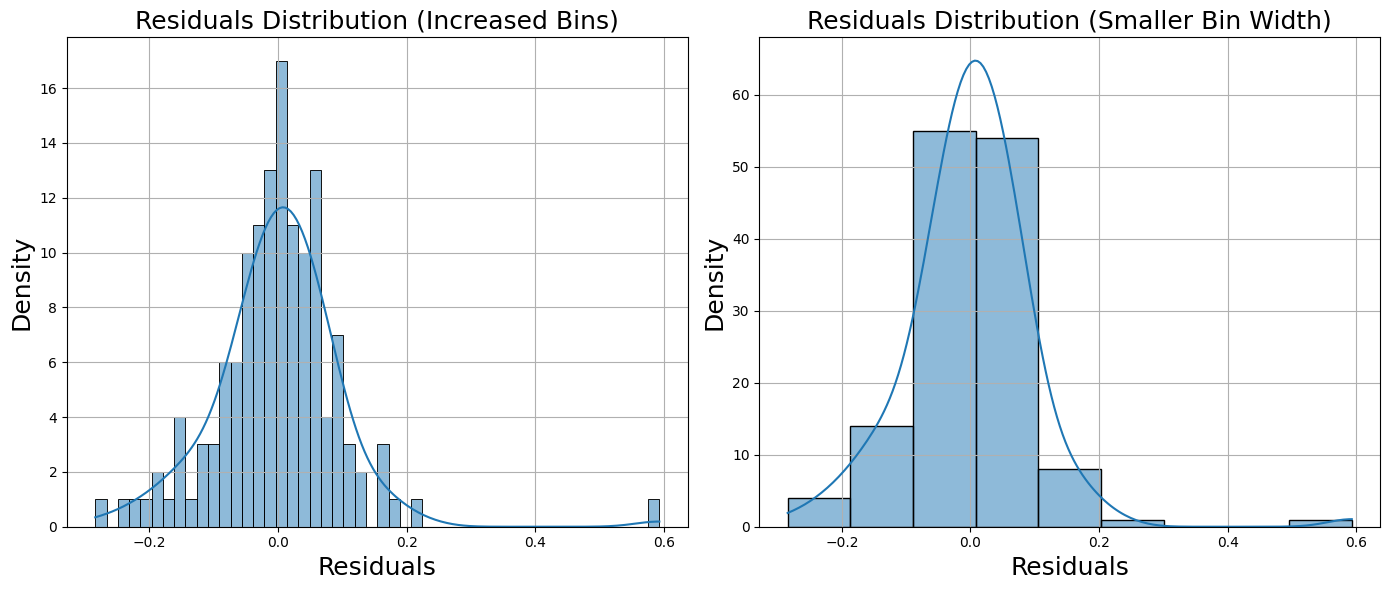

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the histogram with increased number of bins
sns.histplot(model1.resid, kde=True, bins=50, ax=axes[0])
axes[0].set_xlabel('Residuals', fontsize=18)
axes[0].set_ylabel('Density', fontsize=18)
axes[0].set_title('Residuals Distribution (Increased Bins)', fontsize=18)
axes[0].grid()

# Plot the histogram with smaller bin width
sns.histplot(model1.resid, kde=True, binwidth=0.1, ax=axes[1])
axes[1].set_xlabel('Residuals', fontsize=18)
axes[1].set_ylabel('Density', fontsize=18)
axes[1].set_title('Residuals Distribution (Smaller Bin Width)', fontsize=18)
axes[1].grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### **Table 67. Shapiro-Wilk and Jarque-Bera tests**

Shapiro-Wilk Test: ShapiroResult(statistic=0.8999113415017607, pvalue=4.0649488980125665e-08)
Jarque-Bera Test: SignificanceResult(statistic=452.52201748092216, pvalue=5.446185557627817e-99)


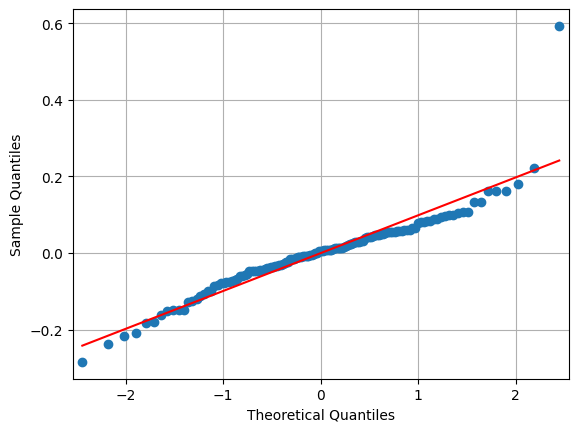

In [ ]:
from scipy.stats import shapiro, jarque_bera
import statsmodels.api as sm

# Shapiro-Wilk Test
shapiro_test = shapiro(model1.resid)
print("Shapiro-Wilk Test:", shapiro_test)

# Jarque-Bera Test
jarque_bera_test = jarque_bera(model1.resid)
print("Jarque-Bera Test:", jarque_bera_test)

# Q-Q Plot
sm.qqplot(model1.resid, line='s')
plt.grid()

### **Table 68. Homoscedasticity tests**

Breusch-Pagan Test: [('Lagrange multiplier statistic', 6.006635896741766), ('p-value', 0.4224471331985067), ('f-value', 0.9935142795489218), ('f p-value', 0.4325138508289139)]
White Test: [('Lagrange multiplier statistic', 52.288921758187826), ('p-value', 0.0024498750784851782), ('f-value', 2.4919091829047675), ('f p-value', 0.00047248165810864816)]


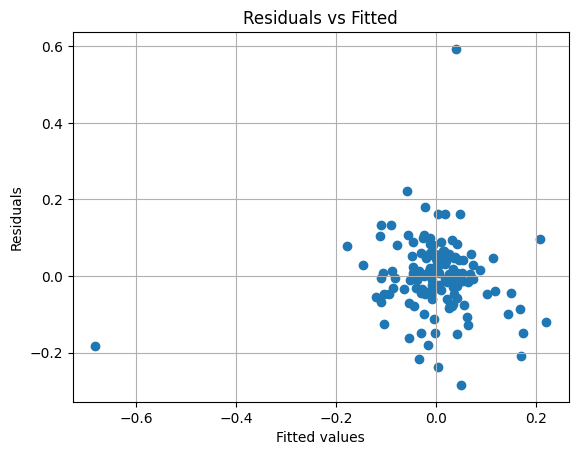

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import matplotlib.pyplot as plt
from statsmodels.compat import lzip

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
# Breusch-Pagan Test
bp_test = het_breuschpagan(model1.resid, model1.model.exog)
print("Breusch-Pagan Test:", lzip(name, bp_test))

# White Test
white_test = het_white(model1.resid, model1.model.exog)
print("White Test:", lzip(name, white_test))

# Residuals vs. Fitted Plot
plt.scatter(model1.fittedvalues, model1.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.grid()
plt.show()

### **Table 70. Heteroskedasticity Consistent (HC3) model**

In [ ]:
import statsmodels.formula.api as sm

formula = 'CL_ExcessReturns ~ SP_ExcessReturns + inflation + indpro + termSpread + yieldSpread + ConsumerCredit'
model2 = sm.ols(formula, df).fit(cov_type = 'HC3')
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:       CL_ExcessReturns   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     10.63
Date:                Sat, 03 Aug 2024   Prob (F-statistic):           1.36e-09
Time:                        13:44:57   Log-Likelihood:                 122.65
No. Observations:                 137   AIC:                            -231.3
Df Residuals:                     130   BIC:                            -210.9
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0309      0.029  

### **Table 71. Auto-correlation test**

In [ ]:
import statsmodels.api as sm
import statsmodels.stats.diagnostic as diag
from statsmodels.stats.stattools import durbin_watson

# Durbin-Watson Test
durbin_watson_test = durbin_watson(model1.resid)
print("Durbin-Watson Test:", durbin_watson_test)

# Breusch-Godfrey test
bg_test = diag.acorr_breusch_godfrey(model1, nlags=6)
print('Breusch-Godfrey Test:')
print('Lagrange Multiplier statistic:', bg_test[0])
print('p-value:', bg_test[1])
print('F-statistic:', bg_test[2])
print('F-test p-value:', bg_test[3])

Durbin-Watson Test: 2.288056955421003
Breusch-Godfrey Test:
Lagrange Multiplier statistic: 18.032212410659604
p-value: 0.006152196931040702
F-statistic: 3.1324926747399964
F-test p-value: 0.00681341464818838


### **Table 72. Jarque-Bera notmality test**

In [ ]:
import statsmodels.stats.api as sm
from statsmodels.compat import lzip

name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.jarque_bera(model1.resid)
lzip(name, test)

[('Jarque-Bera', 452.52201748092216),
 ('Chi^2 two-tail prob.', 5.446185557627817e-99),
 ('Skew', 1.1846364921044215),
 ('Kurtosis', 11.582568123583332)]

### **Table 73. Newly west procedure**

In [ ]:
import statsmodels.formula.api as sm

# using the already defined formula
model3 = sm.ols(formula, data=df).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:       CL_ExcessReturns   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     37.31
Date:                Sat, 03 Aug 2024   Prob (F-statistic):           4.86e-26
Time:                        13:51:22   Log-Likelihood:                 122.65
No. Observations:                 137   AIC:                            -231.3
Df Residuals:                     130   BIC:                            -210.9
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0309      0.012  

### **Table 74. Cook’s distance and leverage plot**

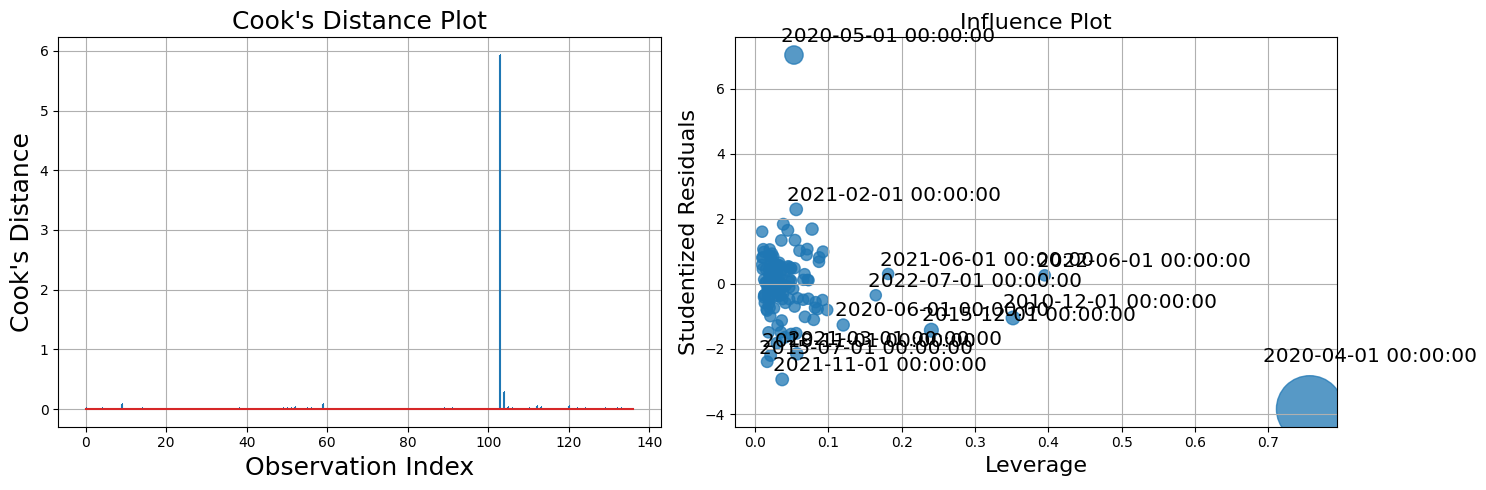

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Get influence statistics
influence = model1.get_influence()

# Cook's Distance
cooks_d, _ = influence.cooks_distance
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel('Observation Index', fontsize=18)
plt.ylabel("Cook's Distance", fontsize=18)
plt.grid()
plt.title("Cook's Distance Plot", fontsize=18)

# Leverage Plot
plt.subplot(1, 2, 2)
sm.graphics.influence_plot(model1, ax=plt.gca())
plt.grid()
plt.tight_layout()

plt.show()

### **Table 75. High influential point identification**

### **Table 76. Residual plot**

High Influence Points Dates:
DatetimeIndex(['2010-12-01', '2015-04-01', '2015-12-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2021-02-01', '2021-03-01',
               '2021-11-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


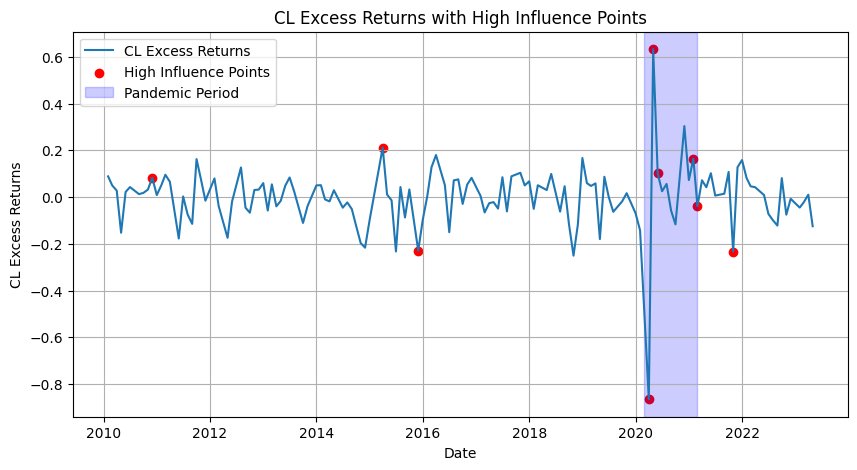

In [ ]:
influence = model1.get_influence()
cooks_d, _ = influence.cooks_distance

# Identify points with high Cook's distance
high_influence_points = np.where(cooks_d > 4 / len(cooks_d))[0]

# Get the date index corresponding to the high influence points
dates_to_drop = df.iloc[high_influence_points].index

print("High Influence Points Dates:")
print(dates_to_drop)

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['CL_ExcessReturns'], label='CL Excess Returns')
plt.scatter(dates_to_drop, df.loc[dates_to_drop, 'CL_ExcessReturns'], color='red', label='High Influence Points')
plt.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-03-01'), color='blue', alpha=0.2, label='Pandemic Period')
plt.xlabel('Date')
plt.ylabel('CL Excess Returns')
plt.grid()
plt.legend()
plt.title('CL Excess Returns with High Influence Points')
plt.show()

### **Table 76. Residual plot**

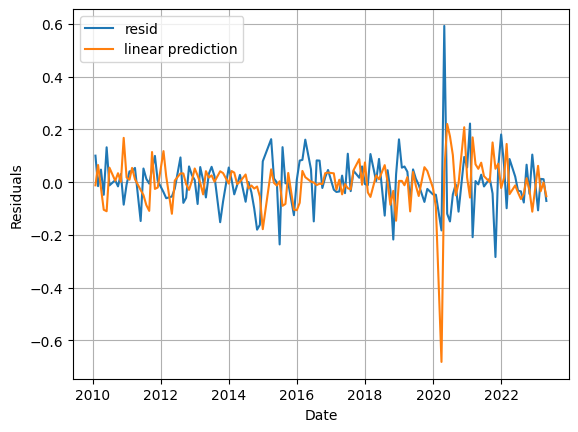

In [ ]:
y_fitted = model1.fittedvalues
residuals = model1.resid

plt.plot(residuals, label='resid')
plt.plot(y_fitted, label='linear prediction')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

### **Table 77. OLS with polynomial terms**

In [ ]:
# formula = 'CL_ExcessReturns ~ SP_ExcessReturns + inflation + indpro + termSpread + yieldSpread + ConsumerCredit'

formula = 'CL_ExcessReturns ~ SP_ExcessReturns + np.power(SP_ExcessReturns, 2) + inflation + indpro + \
termSpread + yieldSpread + ConsumerCredit'
model4 = sm.formula.ols(formula, data=df).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:       CL_ExcessReturns   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     14.76
Date:                Sat, 03 Aug 2024   Prob (F-statistic):           4.93e-14
Time:                        13:58:36   Log-Likelihood:                 122.98
No. Observations:                 137   AIC:                            -230.0
Df Residuals:                     129   BIC:                            -206.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

### **Table 78. OLS with interaction terms**

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# interaction terms
df['SP_ExcessReturns_inflation'] = df['SP_ExcessReturns'] * df['inflation']
df['SP_ExcessReturns_indpro'] = df['SP_ExcessReturns'] * df['indpro']
df['SP_ExcessReturns_termSpread'] = df['SP_ExcessReturns'] * df['termSpread']

df['inflation_indpro'] = df['inflation'] * df['indpro']
df['inflation_termSpread'] = df['inflation'] * df['termSpread']

df['indpro_termSpread'] = df['indpro'] * df['termSpread']

# Formula with selected interaction terms
formula = (
    'CL_ExcessReturns ~ SP_ExcessReturns + inflation + indpro + termSpread + yieldSpread + ConsumerCredit + '
    'SP_ExcessReturns_inflation + SP_ExcessReturns_indpro + SP_ExcessReturns_termSpread + '
    'inflation_indpro + inflation_termSpread + '
    'indpro_termSpread'
)

# OLS model with the interaction terms
model5 = sm.formula.ols(formula, data=df).fit()

print(model5.summary())


                            OLS Regression Results                            
Dep. Variable:       CL_ExcessReturns   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     11.39
Date:                Sat, 03 Aug 2024   Prob (F-statistic):           4.05e-15
Time:                        14:02:01   Log-Likelihood:                 133.58
No. Observations:                 137   AIC:                            -241.2
Df Residuals:                     124   BIC:                            -203.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### **Table 79. Model refit after removing high influential points**

In [ ]:
import statsmodels.formula.api as sm

influence = model1.get_influence()
cooks_d, _ = influence.cooks_distance

# Identify points with high Cook's distance
high_influence_points = np.where(cooks_d > 4 / len(cooks_d))[0]

# Get the date index corresponding to the high influence points
dates_to_drop = df.iloc[high_influence_points].index

# Drop these dates from the DataFrame
df_cleaned = df.drop(index=dates_to_drop)
formula = 'CL_ExcessReturns ~ SP_ExcessReturns + inflation + indpro + termSpread + yieldSpread + ConsumerCredit'
# Refit the model with the cleaned DataFrame
cleaned_model = sm.ols(formula, df_cleaned).fit()
print(cleaned_model.summary())

                            OLS Regression Results                            
Dep. Variable:       CL_ExcessReturns   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     12.57
Date:                Sat, 03 Aug 2024   Prob (F-statistic):           5.54e-11
Time:                        14:03:00   Log-Likelihood:                 156.69
No. Observations:                 128   AIC:                            -299.4
Df Residuals:                     121   BIC:                            -279.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0272      0.014  

### **Table 80.  Code snippet for dummy variable**

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

y_fitted = model1.fittedvalues
residuals = model1.resid

print(residuals.nsmallest(1))
print(residuals.nlargest(1))

Date
2021-11-01   -0.284146
dtype: float64
Date
2020-05-01    0.593049
dtype: float64


### **Table 81. Dummy variable creation**

In [ ]:
df['nov2021'] = np.where(df.index == '2021-11-01', 1, 0)
df['may2020'] = np.where(df.index == '2020-05-01', 1, 0)

formula = 'CL_ExcessReturns ~ SP_ExcessReturns + inflation + indpro + termSpread + yieldSpread + ConsumerCredit\
 + termSpread + nov2021 + may2020'
model6 = sm.ols(formula, df).fit()
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:       CL_ExcessReturns   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     27.55
Date:                Sat, 03 Aug 2024   Prob (F-statistic):           1.83e-24
Time:                        14:04:30   Log-Likelihood:                 151.28
No. Observations:                 137   AIC:                            -284.6
Df Residuals:                     128   BIC:                            -258.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0507      0.015  

### **Table 82. Ramsey's regression specification error test**

In [ ]:
from statsmodels.stats.outliers_influence import reset_ramsey
print(reset_ramsey(model1,degree=4))

<F test: F=4.857980021437261, p=0.0031161687425688644, df_denom=127, df_num=3>


### **Table 83. CUMSUM and CUMSUMSQ tests**

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import breaks_cusumolsresid

# CUSUM and CUSUMSQ tests
cusum_test = breaks_cusumolsresid(model1.resid)
cusum_test_summary = breaks_cusumolsresid(model1.resid, ddof=0)

print("CUSUM Test Summary:", cusum_test)
print("CUSUMSQ Test Summary:", cusum_test_summary)

CUSUM Test Summary: (0.4328404995510638, 0.9920026751962366, [(1, 1.63), (5, 1.36), (10, 1.22)])
CUSUMSQ Test Summary: (0.4328404995510638, 0.9920026751962366, [(1, 1.63), (5, 1.36), (10, 1.22)])


### **Table 84. Rolling regression test**

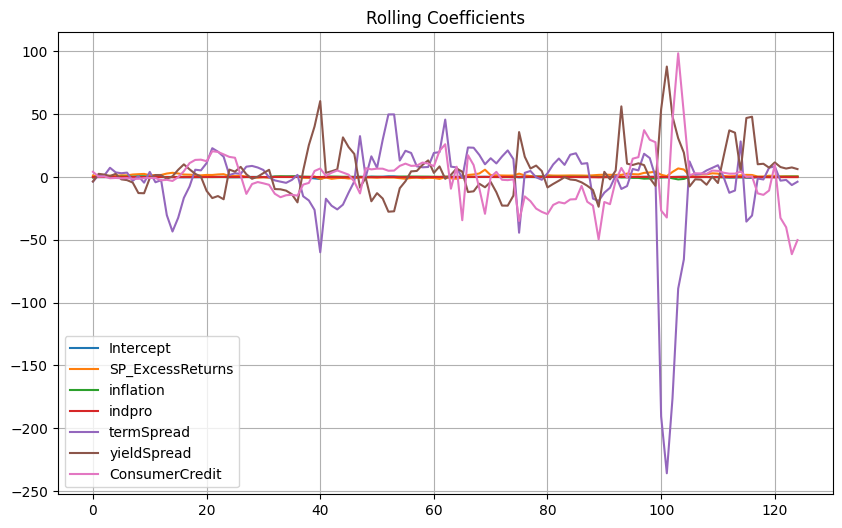

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt

formula = 'CL_ExcessReturns ~ SP_ExcessReturns + inflation + indpro + termSpread + yieldSpread + ConsumerCredit'

# window size
window = 12

# Arrays to store results
rolling_params = []

# Rolling regression
for i in range(window, len(df)):
    rolling_model = sm.ols(formula, data=df.iloc[i-window:i]).fit()
    rolling_params.append(rolling_model.params.values)

# Convert to a DataFrame
rolling_params = np.array(rolling_params)

param_names = rolling_model.params.index

# DataFrame with the correct column names
rolling_df = pd.DataFrame(rolling_params, columns=param_names)

rolling_df.plot(title="Rolling Coefficients", figsize=(10, 6))
plt.grid()
plt.show()

### **Table 85. BrockDechertScheinkman test**

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from statsmodels.tsa.stattools import bds

# Perform the BDS test on the residuals
bds_stat, p_value = bds(model1.resid)

# Print BDS results
print("BDS Test statistic:", bds_stat)
print("BDS Test p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("BDS indicates nonlinearity in the residuals.")
else:
    print("BDS indicates linearity in the residuals.")

BDS Test statistic: 1.8444283825428507
BDS Test p-value: 0.06512073412720783
BDS indicates linearity in the residuals.


### **Table 86. Chow test**

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# Define the breakpoint
breakpoint = len(df)//2

# formula = 'CL_ExcessReturns ~ SP_ExcessReturns + inflation + indpro + termSpread + yieldSpread + ConsumerCredit'

# Prepare the data
Y = df['CL_ExcessReturns']
X = sm.add_constant(df[['SP_ExcessReturns', 'inflation', 'indpro', 'termSpread', 'yieldSpread', 'ConsumerCredit']])

# Full model
full_model = sm.OLS(Y, X).fit()

# Split the data into two parts
X1 = sm.add_constant(df[['SP_ExcessReturns', 'inflation', 'indpro', 'termSpread', 'yieldSpread', 'ConsumerCredit']].iloc[:breakpoint])
Y1 = df['CL_ExcessReturns'].iloc[:breakpoint]
X2 = sm.add_constant(df[['SP_ExcessReturns', 'inflation', 'indpro', 'termSpread', 'yieldSpread', 'ConsumerCredit']].iloc[breakpoint:])
Y2 = df['CL_ExcessReturns'].iloc[breakpoint:]

# Fit models for both segments
model7 = sm.OLS(Y1, X1).fit()
model8 = sm.OLS(Y2, X2).fit()

# Calculate the residual sum of squares (SSR)
ssr_full = full_model.ssr
ssr1 = model7.ssr
ssr2 = model8.ssr

# Calculate the F-statistic for Chow Test
num_restrictions = X.shape[1]
num_params = num_restrictions - 1  # Subtracting the intercept

f_stat = ((ssr_full - (ssr1 + ssr2)) / num_restrictions) / ((ssr1 + ssr2) / (len(Y) - 2 * num_restrictions))
print("Chow Test F-statistic:", f_stat)

# Degrees of freedom
df_num = num_restrictions
df_denom = len(Y) - 2 * num_restrictions

# Calculate the p-value
p_value = stats.f.sf(f_stat, df_num, df_denom)
print("Chow Test p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("The Chow Test indicates a significant structural break.")
else:
    print("The Chow Test does not indicate a significant structural break.")

Chow Test F-statistic: 1.0235239348641676
Chow Test p-value: 0.41815394391584504
The Chow Test does not indicate a significant structural break.


### **Table 87. Implementation of January effect**

In [ ]:
import statsmodels.formula.api as sm

df['nov2021'] = np.where(df.index == '2021-11-01', 1, 0)
df['may2020'] = np.where(df.index == '2020-05-01', 1, 0)
df['jan'] = np.where(df.index.month == 1, 1, 0)

formula = 'CL_ExcessReturns ~ SP_ExcessReturns + inflation + indpro + termSpread + yieldSpread + ConsumerCredit +\
 nov2021 + may2020 + jan'
model9 = sm.ols(formula, df).fit()
print(model9.summary())

                            OLS Regression Results                            
Dep. Variable:       CL_ExcessReturns   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     25.55
Date:                Sat, 03 Aug 2024   Prob (F-statistic):           1.38e-24
Time:                        14:09:44   Log-Likelihood:                 153.48
No. Observations:                 137   AIC:                            -287.0
Df Residuals:                     127   BIC:                            -257.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0545      0.015  